In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
import re

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

In [9]:
with open("resources/norm_wiki_sample.txt", "r") as f:
    wiki_text = f.read()

In [10]:
TOKENS = nltk.tokenize.word_tokenize(wiki_text)
for i, token in enumerate(TOKENS):
    if len(re.findall("[0-9]+", token)) != 0:
        TOKENS[i] = "<num>"

In [11]:
def generate_vocabs(tokens):
    word_to_id = {token: i for i, token in enumerate(sorted(set(tokens)))}
    if "<unk>" not in tokens:
        word_to_id["<unk>"] = len(word_to_id)
    id_to_word = {i: token for token, i in word_to_id.items()}
    return word_to_id, id_to_word

def generate_instances_words(tokens, window_halfsize):
    for i in range(window_halfsize, len(tokens)-window_halfsize):
        context = tokens[i-window_halfsize:i] + tokens[i+1:window_halfsize]
        target = tokens[i]
        yield context, target

def generate_word_vecs(tokens, window_halfsize, word_to_id):
    vocab_size = len(word_to_id)
    for context, target in generate_instances_words(tokens, window_halfsize):
        context_vec = np.zeros(vocab_size)
        for word in context:
            context_vec[word_to_id[word]] += 1
        context_vec /= len(context)

        target_vec = np.zeros(vocab_size)
        target_vec[word_to_id[target]] = 1
        yield context_vec, target_vec

In [21]:
class WordVecGenerator:
    def __init__(self, vocab: set, window_halfsize: int):
        self.word_to_id = {token: i for i, token in enumerate(sorted(vocab))}
        if "<unk>" not in vocab:
            self.word_to_id["<unk>"] = len(self.word_to_id)
        self.id_to_word = {i: token for token, i in self.word_to_id.items()}
        self.vocab_size = len(self.word_to_id)
        self.win_halfsize = window_halfsize

    def _process_token(self, token):
        if token in self.word_to_id:
            return token
        return "<unk>"

    def _get_index(self, token):
        token = self._process_token(token)
        return self.word_to_id[token]

    def get_one_hot(self, token):
        res = np.zeroes(self.vocab_size)
        res[self._get_index(token)] = 1
        return res

    def generate_instances_words(self, tokens):
        for i in range(self.win_halfsize, len(tokens)-self.win_halfsize):
            context = tokens[i-self.win_halfsize:i] + tokens[i+1:self.win_halfsize]
            target = tokens[i]
            yield context, target

    def generate_word_vecs(self, tokens):
        for context, target in self.generate_instances_words(tokens):
            context_vec = np.zeros(self.vocab_size)
            for word in context:
                if word not in self.word_to_id:
                    word = "<unk>"
                context_vec[self.word_to_id[word]] += 1
            context_vec /= len(context)

            target_vec = np.zeros(self.vocab_size)
            if target not in self.word_to_id:
                target = "<unk>"
            target_vec[self.word_to_id[target]] = 1
            yield context_vec, target_vec

In [24]:
class WordVecDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        global DEVICE
        x = torch.tensor(self.data[index], dtype=torch.double, device=DEVICE)
        y = torch.tensor(self.targets[index], dtype=torch.double, device=DEVICE) 
        return x, y

In [28]:
tokens_subset = TOKENS[:10000]
word_vec_gen = WordVecGenerator(set(tokens_subset), 5)

data, targets = [], []
ngrams = word_vec_gen.generate_word_vecs(tokens_subset)
for context_vec, target_vec in ngrams:
    data.append(context_vec)
    targets.append(target_vec)

dataset = WordVecDataset(data, targets)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

In [29]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.hidden = nn.Linear(vocab_size, embedding_dim)
        self.relu = nn.ReLU()
        self.output = nn.Linear(embedding_dim, vocab_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs):
        hidden = self.relu(self.hidden(inputs))
        out = self.softmax(self.output(hidden))
        return out

In [31]:
losses = []
loss_function = nn.CrossEntropyLoss()

model = CBOWModel(word_vec_gen.vocab_size, 50)
model = model.double()
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    total_loss = 0
    for context_vec, target_vec in dataloader:
        # context_vec = torch.tensor(context_vec, dtype=torch.double, device=DEVICE)
        # context_vec = torch.reshape(context_vec, (1, -1))
        # target_vec = torch.tensor(target_vec, dtype=torch.double, device=DEVICE)
        # target_vec = torch.reshape(context_vec, (1, -1))

        model.zero_grad()
        probs = model(context_vec)
        loss = loss_function(probs, target_vec)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    losses.append(total_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {losses[-1]}")

Epoch: 0 | Loss: 7919.575555857831
Epoch: 10 | Loss: 7863.886172610739
Epoch: 20 | Loss: 7809.545704477734
Epoch: 30 | Loss: 7773.707535781884
Epoch: 40 | Loss: 7757.41392919287
Epoch: 50 | Loss: 7749.291557794115
Epoch: 60 | Loss: 7742.470501179652
Epoch: 70 | Loss: 7738.784101492824
Epoch: 80 | Loss: 7735.873394506536
Epoch: 90 | Loss: 7733.621568827935


In [47]:
temp_input = np.random.random(len(word_to_id))
temp_input = torch.tensor(temp_input, dtype=torch.double, device=DEVICE)
temp_input = torch.reshape(temp_input, shape=(1,-1))
temp_output = model(temp_input)

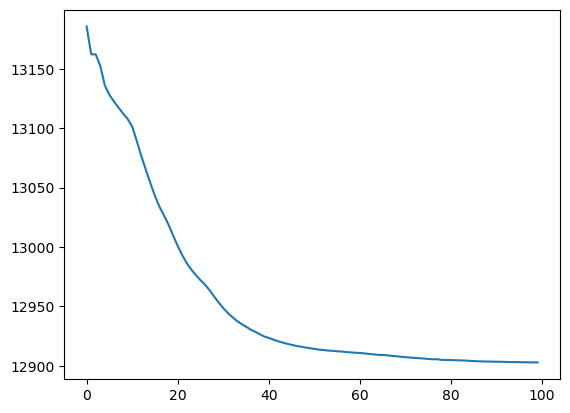

In [19]:
plt.plot(losses)

In [27]:
model.eval()
sentence = "Hi, Even though I am very intelligent I am also very gay"
test_tokens = nltk.word_tokenize(sentence)
list(word_vec_gen.generate_instances_words(test_tokens))

[(['Hi', ',', 'Even', 'though', 'I'], 'am'),
 ([',', 'Even', 'though', 'I', 'am'], 'very'),
 (['Even', 'though', 'I', 'am', 'very'], 'intelligent')]